In [8]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch

plt.close('all')

plt.rc('font', size=14)          # controls default text sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [9]:
## Parameters
exp_sys = 'BrownianBridge' # experiment system BrownianBridge, NoisyOscillator, NyquistJohnson, Highdim
init_dist = 'Gaussian' # initial distribution Gaussian, Circle
target_dist = '2G' # 2G, 4G, Circle
N = 2000
tf = 1
T = 1000

In [10]:
## Load data
X_f = np.load('exp_result_data/X_f_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))
X_p = np.load('exp_result_data/X_p_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))
x_0 = np.load('exp_result_data/x_0_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))
y = np.load('exp_result_data/y_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))

t_N = torch.linspace(0.0, tf, T).repeat(N,1).reshape(N,T,1).permute(1,0,2) # shape (T,N,1)

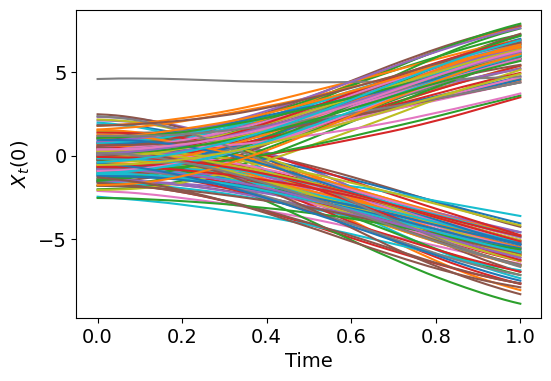

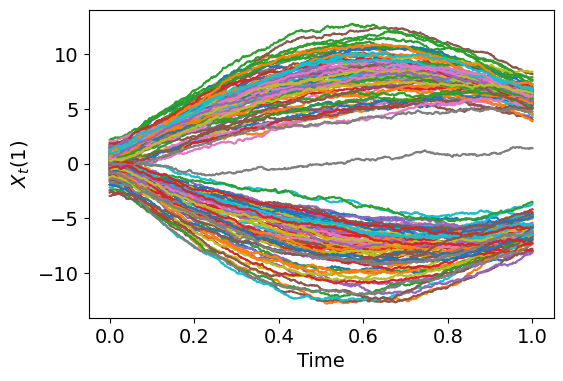

In [12]:
idx = torch.randperm(N)[:150]

## X trajectory respect to time
for i in range(X_p.shape[2]):
    plt.figure(figsize=(6,4))
    plt.plot(t_N[:,0,0], X_p[:,idx,i])
    plt.xlabel('Time')
    plt.ylabel(fr'$X_t({i})$')
plt.show()


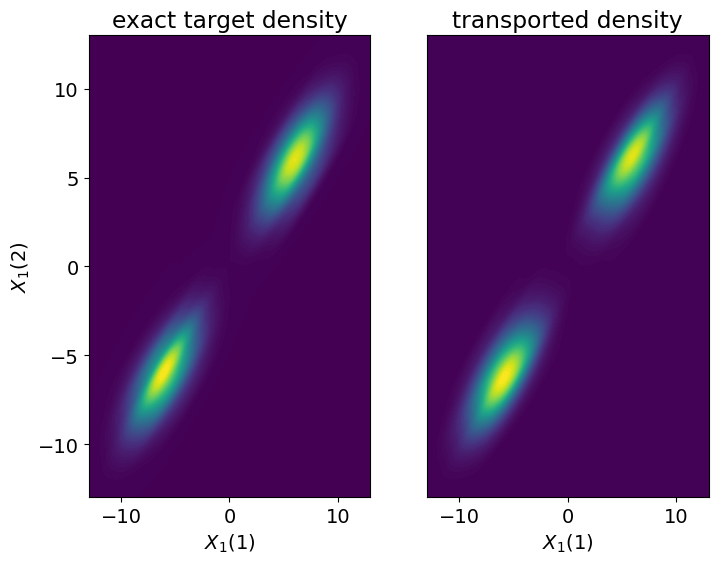

In [16]:
## Heatmap 
plt.figure(figsize=(8, 6))

# Plot the 2D heat density map for X_f
plt.subplot(1, 2, 1)
sns.kdeplot(
    x=X_f[-1, :, 0],
    y=X_f[-1, :, 1],
    # cmap="Reds",
    cmap="viridis",
    # cmap="mako",
    fill=True,
    cbar=True*0,
    levels=100,
    thresh=-0.01,
)
plt.title("exact target density")
plt.xlabel(r"$X_1(1)$")
plt.ylabel(r"$X_1(2)$")
plt.xlim(-13,13)
plt.ylim(-13,13)

# Plot the 2D heat density map for X_b
plt.subplot(1, 2, 2)
sns.kdeplot(
    x=X_p[-1, :, 0],
    y=X_p[-1, :, 1],
    # cmap="Greens",
    cmap="viridis",
    # cmap="mako",
    fill=True,
    cbar=True*0,
    levels=100,
    thresh=0,
)
plt.title("transported density")
plt.xlabel(r"$X_1(1)$")
plt.xlim(-13,13)
plt.ylim(-13,13)
plt.yticks([])
plt.show()

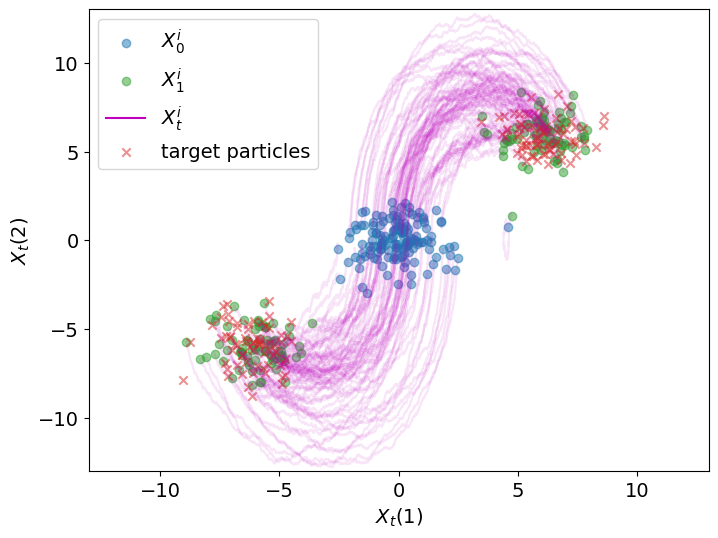

In [18]:
## Plot X trajectory and compare with target density

plt.figure(figsize=(8,6 ))
for i in idx: 
    plt.plot(X_p[:,i,0], X_p[:,i,1], color='m', alpha=0.1)

plt.scatter(X_p[0,idx,0], X_p[0,idx,1], color='C0', label= r'$X_0^i$', alpha=0.5)
plt.scatter(X_p[-1,idx,0], X_p[-1,idx,1], color='C2', label= r'$X_1^i$', alpha=0.5)
plt.plot([],[],color='m',label=r'$X_t^i$')


plt.scatter(y[idx,0], y[idx,1], color='C3', label= 'target particles', alpha=0.5, marker='x')

plt.xlim(-13,13)
plt.ylim(-13,13)

plt.legend(loc=2) # 2 G
plt.xlabel(r'$X_t(1)$')
plt.ylabel(r'$X_t(2)$')
plt.show()

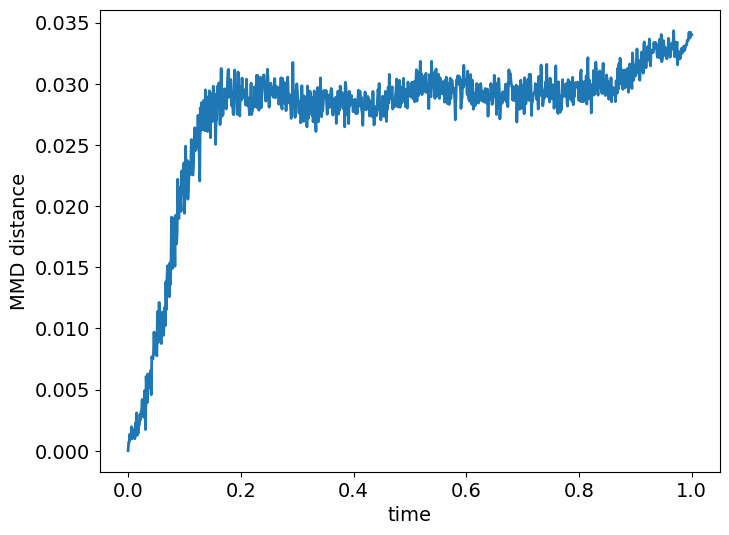

In [21]:
## Generate MMD plot

def kernel(X,Y,sigma=1):
    return torch.exp(-sigma*torch.cdist(X,Y)*torch.cdist(X,Y))

def MMD(XY, XY_target, kernel,sigma = 1/(2*1**2)):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    XY = XY.to(device)
    XY_target = XY_target.to(device)
    return torch.sqrt(kernel(XY,XY,sigma=sigma).mean() + kernel(XY_target,XY_target,sigma=sigma).mean() - 2*kernel(XY,XY_target,sigma=sigma).mean())

ls = 2
sigma =1/(2*ls**2)

x_0_mmd = torch.tensor(x_0)
y_mmd = torch.tensor(y)
mmd_norm = MMD(x_0_mmd, y_mmd, kernel,sigma).item()

mmd_list = []
if torch.backends.mps.is_available():
        device = torch.device('mps')
else:
        device = torch.device('cpu')

X_p_mmd = torch.tensor(X_p).to(device)
X_f_mmd = torch.tensor(X_f).to(device)
for i in range(T):
    # if i% 10 ==0:
    #     print(i)
    #     quantile = torch.quantile(torch.cdist(X_p_mmd[i,], X_f_mmd[i,]).reshape(1,-1),q=0.25).item()
    #     print(quantile)
    mmd_list.append(MMD(X_p_mmd[i,], X_f_mmd[i,], kernel,sigma).item()/mmd_norm)

plt.figure(figsize=(8,6 ))
plt.plot(t_N[:,0,0],mmd_list,lw=2)
plt.xlabel(r'time')
plt.ylabel(r'MMD distance')  
plt.show()

In [24]:
## Generate Wasserstein (W2) plot

import ot
w2_dist = []
# Uniform weights if distributions are unweighted
a = np.ones(N) / N # Uniform weights for X
b = np.ones(N) / N # Uniform weights for Y

dist_0 =  ot.dist(x_0, y) 
w2_dist_norm = np.sqrt(ot.emd2(a, b, dist_0))

for i in range(T):
    # if i% 10 ==0:
    #     print(i)
    # Compute the cost matrix (usually the Euclidean distance matrix)
    dist =  ot.dist(X_p[i,], X_f[i,]) 

    # Compute the Wasserstein distance (emd2 returns the squared distance)
    w2_dist.append(np.sqrt(ot.emd2(a, b, dist))/w2_dist_norm)

plt.figure(figsize=(8,6 ))
plt.plot(t_N[:,0,0],w2_dist,lw=2)
plt.xlabel(r'time')
plt.ylabel(r'$W_2$ distance')
plt.show()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
